In [2]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from src.utils.data_utils import get_related_videos_with_keywords, keyword_searcher
from src.utils.general_utils import plot_wordcloud
from src.utils.evaluation_utils import diff_in_diff
from sklearn.linear_model import LinearRegression

In [3]:
DATA_PATH = "../data"
target_sport_data = pd.read_parquet(DATA_PATH+"/target_sport_data_mt.parquet",engine="fastparquet")

In [4]:
target_sport_data.head(5)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,upload_year_month,engagement_rate
0,Sports,UCzTF8VGf1wY4juDDmDqgxWA,2019-11-15 10:33:44.027819,hello peeps a quick attempt at filming on my g...,0.0,_oJ_HVk59qA,169,13.0,"gopro,hero,hero4,football,first,attempt,gopro ...",FIRST GOPRO HERO4 VIDEO SHOOTOUT,2016-03-08,342.0,554,0.038012
1,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:42:32.431690,The England national football team is in disar...,1.0,CpE_LBqzh40,162,4.0,"fabio capello,england,john terry,football asso...",England football team in disarray,2012-02-09,351.0,505,0.014245
2,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:03.228877,English football fans have reacted with shock ...,4.0,ftiJ8TfapoI,149,14.0,"world_cup,spain,portugal,russia,roshan muhamme...",England humiliated over World Cup bid,2010-12-02,4038.0,491,0.004458
3,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:13.888521,"The world soccer governing body, Fifa, has ack...",1.0,Pd9WmFgLbZg,138,0.0,"world_cup,johannesburg,joburg,roshan muhammed ...",How good is the Jabulani?,2010-07-29,222.0,486,0.004505
4,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:16.292029,The whole continent of Africa is in mourning a...,0.0,AldYoZRbT2w,141,0.0,"world_cup,ghana,vuvuzela,south africa,roshan m...",Africans heartbroken after Ghana World Cup exit,2010-07-29,193.0,486,0.000000


In [5]:
target_sports = [
    "football","basketball","wrestling","soccer","boxing","hockey","mma","golf","baseball","tennis","cricket","rugby","gymnastics"
,"volleyball","skating","karate"]

In [6]:
result_df = pd.DataFrame()

# Loop through each sport and calculate counts
for sport in target_sports:
    # Filter data for the specific sport
    sport_specific_data = target_sport_data[target_sport_data['tags'].apply(lambda x: sport in x)]
    
    # Group by upload_date (converted to monthly periods) and count
    counts = sport_specific_data.groupby(sport_specific_data["upload_date"].dt.to_period('M')).size()
    
    # Add the counts as a row to the result DataFrame
    result_df.loc[sport, counts.index] = counts

# Replace NaN with 0 for clarity
result_df = result_df.fillna(0)

# Display the result
print(result_df)

/Users/pikkun0907/Library/CloudStorage/OneDrive-epfl.ch/ADA/ada-2024-project-robodatapioneers2024/.venv/lib/python3.9/site-packages/pandas/core/indexing.py:2421: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  new_ix = Index(new_ix)
/Users/pikkun0907/Library/CloudStorage/OneDrive-epfl.ch/ADA/ada-2024-project-robodatapioneers2024/.venv/lib/python3.9/site-packages/pandas/core/indexing.py:2421: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  new_ix = Index(new_ix)
/Users/pikkun0907/Library/CloudStorage/OneDrive-epfl.ch/ADA/ada-2024-project-robodatapioneers2024/.venv/lib/python3.9/site-packages/pandas/core/indexing.py:2421: FutureWarning: Dty

            2006-05  2006-06  2006-07  2006-08  2006-09  2006-10  2006-11  \
football          1        1        2        2        1        5        4   
basketball        1        1        1        1        0        7        4   
wrestling        58       30       42       46       54       47       45   
soccer           19        4        2        1        2        3        1   
boxing            0        1        3        0        0        1        4   
hockey            0        0        7        0        4        1        5   
mma               1        0        1        5        0        3        5   
golf              0        0        0        1        8        2        1   
baseball          1        0        0        0        0        0        2   
tennis            4        2        0        0        8        0        1   
cricket           0        0        0        0        0        0        0   
rugby             0        0        0        0        0        2        1   

/Users/pikkun0907/Library/CloudStorage/OneDrive-epfl.ch/ADA/ada-2024-project-robodatapioneers2024/.venv/lib/python3.9/site-packages/pandas/core/indexing.py:2421: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  new_ix = Index(new_ix)
/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_31560/284321700.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df = result_df.fillna(0)


In [7]:
result_df

,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,...,2019-07,2019-08,2019-09,2019-10,2006-04,2006-02,2006-03,2019-11,2005-05,2006-01
football,1,1,2,2,1,5,4,8,7,9,...,7973,10014,10789,697,b'',b'',b'',b'',b'',b''
basketball,1,1,1,1,0,7,4,11,5,3,...,4485,4238,4204,371,2,b'',b'',b'',b'',b''
wrestling,58,30,42,46,54,47,45,26,22,28,...,10953,1962,1974,149,20,1,7,2,b'',b''
soccer,19,4,2,1,2,3,1,5,16,4,...,3283,3870,4003,294,1,0,1,0,b'',b''
boxing,0,1,3,0,0,1,4,5,5,60,...,4952,3559,4446,499,0,0,0,0,b'',b''
hockey,0,0,7,0,4,1,5,7,21,164,...,2561,2567,2711,205,0,0,0,0,b'',b''
mma,1,0,1,5,0,3,5,3,4,9,...,12237,2641,2882,413,2,0,0,0,b'',b''
golf,0,0,0,1,8,2,1,3,8,3,...,1455,1302,1110,90,1,0,0,0,b'',b''
baseball,1,0,0,0,0,0,2,1,2,1,...,3438,3487,3310,229,1,0,0,0,b'',b''
tennis,4,2,0,0,8,0,1,0,18,10,...,1152,961,718,51,0,0,0,0,b'',b''


In [8]:
result_df=result_df.iloc[:,:-6]

In [9]:
# Replace NaN with 0 for clarity
result_df = result_df.fillna(0)

# Perform accumulation (cumulative sum) row-wise
result_df = result_df.apply(lambda row: row.cumsum(), axis=1)

# Display the accumulated result
print(result_df)

            2006-05  2006-06  2006-07  2006-08  2006-09  2006-10  2006-11  \
football          1        2        4        6        7       12       16   
basketball        1        2        3        4        4       11       15   
wrestling        58       88      130      176      230      277      322   
soccer           19       23       25       26       28       31       32   
boxing            0        1        4        4        4        5        9   
hockey            0        0        7        7       11       12       17   
mma               1        1        2        7        7       10       15   
golf              0        0        0        1        9       11       12   
baseball          1        1        1        1        1        1        3   
tennis            4        6        6        6       14       14       15   
cricket           0        0        0        0        0        0        0   
rugby             0        0        0        0        0        2        3   

In [10]:
result_df

,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
football,1,2,4,6,7,12,16,24,31,40,...,385855,393179,401441,410377,418281,424898,432871,442885,453674,454371
basketball,1,2,3,4,4,11,15,26,31,34,...,287731,295638,304759,311343,316671,321453,325938,330176,334380,334751
wrestling,58,88,130,176,230,277,322,348,370,398,...,90787,92875,94867,96912,98791,100677,111630,113592,115566,115715
soccer,19,23,25,26,28,31,32,37,53,57,...,215881,219238,222832,226716,230434,233486,236769,240639,244642,244936
boxing,0,1,4,4,4,5,9,14,19,79,...,168904,172739,177341,181771,186599,191301,196253,199812,204258,204757
hockey,0,0,7,7,11,12,17,24,45,209,...,126852,130533,134612,138311,141347,144218,146779,149346,152057,152262
mma,1,1,2,7,7,10,15,18,22,31,...,132901,135901,139296,142128,145290,148557,160794,163435,166317,166730
golf,0,0,0,1,9,11,12,15,23,26,...,41216,42270,43384,44541,45609,46893,48348,49650,50760,50850
baseball,1,1,1,1,1,1,3,4,6,7,...,88302,90802,94044,97835,101350,104678,108116,111603,114913,115142
tennis,4,6,6,6,14,14,15,15,33,43,...,43203,43663,44587,45203,46161,46944,48096,49057,49775,49826


In [49]:
column=result_df.iloc[:,-1]
column=column.sort_values(ascending=False)

<Axes: >

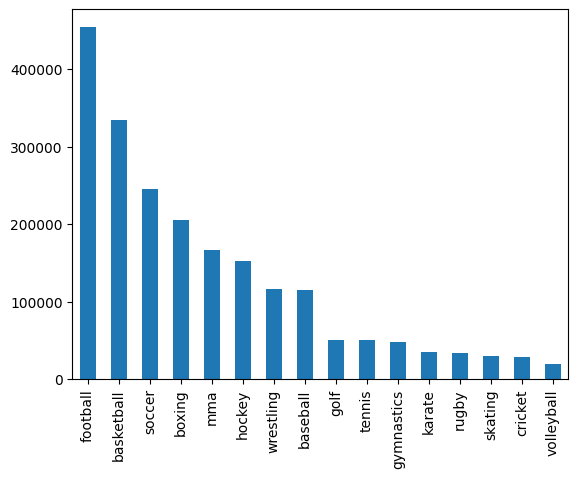

In [50]:

column.plot(kind='bar')

In [40]:
football_acum=result_df.iloc[0,:]
hockey_acum=result_df.iloc[5,:]

In [48]:
football_acum.index

Index([2006-05, 2006-06, 2006-07, 2006-08, 2006-09, 2006-10, 2006-11, 2006-12,
       2007-01, 2007-02,
       ...
       2019-01, 2019-02, 2019-03, 2019-04, 2019-05, 2019-06, 2019-07, 2019-08,
       2019-09, 2019-10],
      dtype='object', length=162)

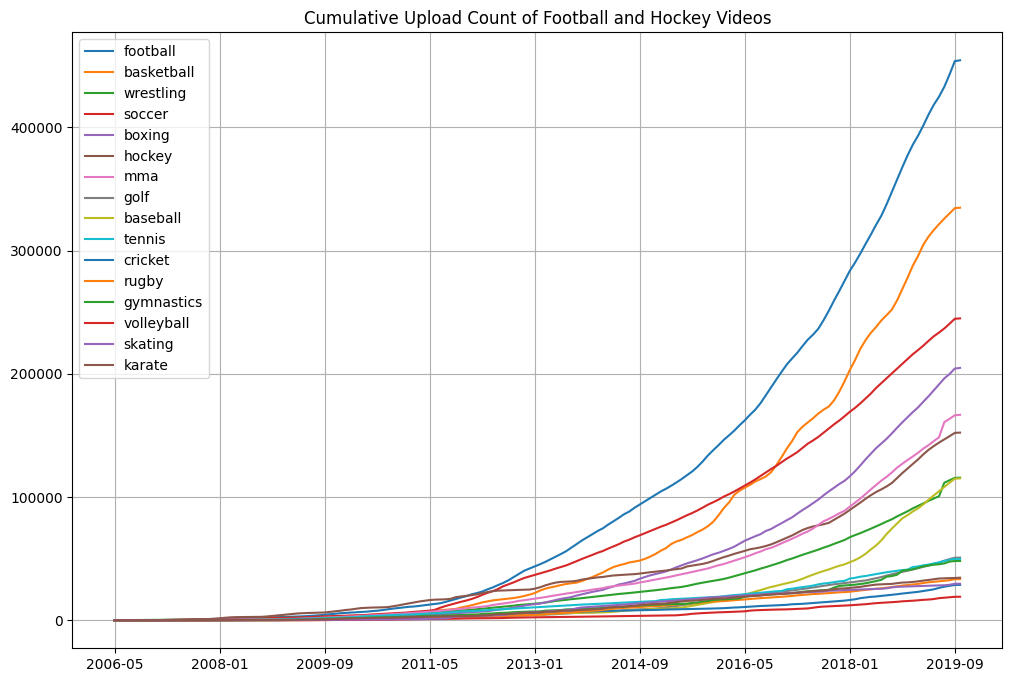

In [53]:
plt.figure(figsize=(12, 8))
for index, sport in enumerate(target_sports):
    a=result_df.iloc[index,:]
    a.plot(kind='line',label=sport)
plt.legend()
plt.grid(True)
plt.title("Cumulative Upload Count of Football and Hockey Videos")
tick_positions = range(0, len(football_acum), 4)
# plt.xticks(tick_positions, monthly_engagement['upload_year_month'].astype(str).iloc[tick_positions], rotation=45)
plt.show()

In [52]:
target_sport_data

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,upload_year_month,engagement_rate
0,Sports,UCzTF8VGf1wY4juDDmDqgxWA,2019-11-15 10:33:44.027819,hello peeps a quick attempt at filming on my g...,0.0,_oJ_HVk59qA,169,13.0,"gopro,hero,hero4,football,first,attempt,gopro ...",FIRST GOPRO HERO4 VIDEO SHOOTOUT,2016-03-08,342.0,554,0.038012
1,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:42:32.431690,The England national football team is in disar...,1.0,CpE_LBqzh40,162,4.0,"fabio capello,england,john terry,football asso...",England football team in disarray,2012-02-09,351.0,505,0.014245
2,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:03.228877,English football fans have reacted with shock ...,4.0,ftiJ8TfapoI,149,14.0,"world_cup,spain,portugal,russia,roshan muhamme...",England humiliated over World Cup bid,2010-12-02,4038.0,491,0.004458
3,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:13.888521,"The world soccer governing body, Fifa, has ack...",1.0,Pd9WmFgLbZg,138,0.0,"world_cup,johannesburg,joburg,roshan muhammed ...",How good is the Jabulani?,2010-07-29,222.0,486,0.004505
4,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:16.292029,The whole continent of Africa is in mourning a...,0.0,AldYoZRbT2w,141,0.0,"world_cup,ghana,vuvuzela,south africa,roshan m...",Africans heartbroken after Ghana World Cup exit,2010-07-29,193.0,486,0.000000
